# Autoencoder - mouse3

This notebook contains code accompanying the SpikeStability package for the autoencoder analysis related to Fig. 5 of the manuscript 'Tracking neural activity from the same cells during the entire adult life of mice'. More detail is provided in autoencoder_analysis_mouse1 file.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython import display
import PIL
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import layers, losses, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import glob
import time

#looking at the latent space 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
from numpy.random import seed
seed(1)

In [3]:
import umap

In [4]:
import os
os.chdir('..')

# Load Dataset


In [6]:
your_path_to_data_dir = ''

In [7]:
df_all = pd.read_csv(your_path_to_data_dir+'mouse3_postprocess_data.csv')
df_postprocess = pd.read_csv(your_path_to_data_dir+'mouse3_postprocess_data_strong.csv')

In [9]:
#outlier data
df_anomaly = pd.read_csv(your_path_to_data_dir+'anomaly_spikes.csv')
X_anomaly = df_anomaly[['t'+str(i) for i in range(1, 31)]].values
labels_anomaly = df_anomaly['label_anomaly'].values

In [10]:
df = df_all

# Model architecture

In [11]:
spike_cols = ['t'+str(i) for i in range(1, 31)]
spikes = df[spike_cols].values

In [12]:
#params for AE
latent_dim = 2
dropout_rate = 0.2
input_shape = (spikes.shape[1],)
nb_neurons = df['neuron Wavemap'].unique().shape[0]
nb_channels = df['channel'].unique().shape[0]

#function based API for Keras
## encoder part
inputs = layers.Input(shape=input_shape)
inputs_channel = layers.Input(shape=(nb_channels,))
combined = layers.concatenate([inputs, inputs_channel])

x = layers.Dense(100, activation=layers.LeakyReLU(alpha=0.3))(combined)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(100, activation=layers.LeakyReLU(alpha=0.3))(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(latent_dim, activation=layers.LeakyReLU(alpha=0.3),
                activity_regularizer=regularizers.l2(1e-3))(x)

## classifier part
#need input of channel information


class_prob = layers.Dense(nb_neurons, activation="softmax",
                          name='classifier')(x)
encoded = layers.Dense(latent_dim, activation=layers.LeakyReLU(alpha=0.3),
                       name="latent")(x)

## decoder part
x = layers.Dense(100, activation=layers.LeakyReLU(alpha=0.3))(encoded)
x = layers.Dense(100, activation=layers.LeakyReLU(alpha=0.3))(x)
decoded = layers.Dense(input_shape[0], name='reconstruction')(x)

## full model
autoencoder = Model(inputs=[inputs, inputs_channel], outputs=[decoded, class_prob])
encoder = Model(inputs=[inputs, inputs_channel], outputs=encoded)
classifier = Model(inputs=[inputs, inputs_channel], outputs=class_prob)

# Train and test on 50/50 part of the dataset



## Training

In [13]:
X_test_all_spikes = df[df['dates'] >= '2021-01-27'][spike_cols].values
labels_test_all_spikes = df[df['dates'] >= '2021-01-27']['neuron Wavemap'].values
channels_test_all_spikes = df[df['dates'] >= '2021-01-27']['channel'].values

In [14]:
df_ = df_postprocess.sort_values('dates')

In [15]:
df_train, df_test = train_test_split(df_, shuffle=False, test_size=0.6)
df_train, df_eval = train_test_split(df_train, shuffle=False, test_size=0.2)

In [16]:
df_train['dates'].unique(), df_eval['dates'].unique(), df_test['dates'].unique()

(array(['2020-07-30', '2020-08-12', '2020-09-18', '2020-10-20',
        '2020-11-05'], dtype=object),
 array(['2020-11-05', '2020-12-19', '2020-12-27'], dtype=object),
 array(['2020-12-27', '2021-01-27', '2021-02-10', '2021-03-22',
        '2021-04-06', '2021-05-23', '2021-06-12', '2021-07-10',
        '2021-07-29', '2021-11-15'], dtype=object))

In [17]:
X_train, X_eval, X_test = df_train[spike_cols].values, df_eval[spike_cols].values, df_test[spike_cols].values
labels_train, labels_eval, labels_test =  df_train['neuron Wavemap'].values, df_eval['neuron Wavemap'].values, df_test['neuron Wavemap'].values

In [18]:
#make sure labels are encoded
y_train = tf.keras.utils.to_categorical(labels_train, nb_neurons)
y_eval = tf.keras.utils.to_categorical(labels_eval, nb_neurons)
y_test = tf.keras.utils.to_categorical(labels_test, nb_neurons)

In [19]:
#make sure channels are encoded
nb_channels = len(df_train['channel'].unique())
mapping_dic = dict([(val, i) for i, val in enumerate(df_train['channel'].unique())])

channels_train = list(map(mapping_dic.get, df_train['channel'].values))
channels_test = list(map(mapping_dic.get, df_test['channel'].values))
channels_eval = list(map(mapping_dic.get, df_eval['channel'].values))
channels_test_all_spikes = list(map(mapping_dic.get, channels_test_all_spikes))

channels_train_enc = tf.keras.utils.to_categorical(channels_train, nb_channels)
channels_test_enc = tf.keras.utils.to_categorical(channels_test, nb_channels)
channels_eval_enc = tf.keras.utils.to_categorical(channels_eval, nb_channels)
channels_test_all_spikes_enc = tf.keras.utils.to_categorical(channels_test_all_spikes, nb_channels)

In [34]:
#training
autoencoder.compile(optimizer='adam',
                    loss=["mse", "categorical_crossentropy"],
                    loss_weights=[.01, 1],
                    metrics=['accuracy'])
autoencoder.save_weights('model_mouse3.h5') ##if you want to retrain multiple times
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 40)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          4100        concatenate[0][0]            

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
#custom callback for visualization of the training process
class ImageReconstruction(tf.keras.callbacks.Callback):
  def __init__(self, eval_data, eval_labels, eval_channels, save_interval, savedir):
    super(ImageReconstruction, self).__init__()
    self.savedir = savedir
    self.eval_data = eval_data
    self.eval_channels = eval_channels
    self.save_interval = save_interval
    self.eval_labels = eval_labels
    self.color_list = sns.color_palette('husl', len(np.unique(eval_labels)))
    self.color_dic = dict([(neuron, color) for neuron, color in zip(np.unique(self.eval_labels),
                                                                              self.color_list)])

  def on_epoch_end(self, epoch, logs=None):
    scale = (np.min(self.eval_data) - 10, np.max(self.eval_data) + 10)
    if epoch % self.save_interval == 0:
      fig, axs = plt.subplots(2, len(np.unique(self.eval_labels)), figsize=(20, 4))
      fig.suptitle('Epoch '+str(epoch), y=1.05)
      for i, neuron_label in enumerate(np.unique(self.eval_labels)):
        mask = self.eval_labels == neuron_label 
        mean_waveform = np.mean(self.eval_data[mask], axis=0)
        corresponding_channel = self.eval_channels[mask][0]
        axs[0, i].set_ylim(scale)
        axs[0, i].plot(mean_waveform,
                      c=self.color_dic[neuron_label], lw=5.)
        axs[0, i].set_title('original')
        axs[0, i].set_xticks([])
        axs[0, i].set_yticks([])
        #reconstruction
        decoded_waveform, pred_label = self.model([np.reshape(mean_waveform, (1, -1)),
                                                  np.reshape(corresponding_channel, (1, -1))])
        pred_label = np.argmax(pred_label)
        axs[1, i].plot(decoded_waveform[0],
                      c=self.color_dic[pred_label], lw=5.)
        axs[1, i].set_title('reconstructed')
        axs[1, i].set_xticks([])
        axs[1, i].set_ylim(scale)
        axs[1, i].set_yticks([])
      fig.tight_layout()
      plt.savefig(self.savedir + '/' + f'epoch_{epoch}')
      plt.show()

class OutlierEvaluation(tf.keras.callbacks.Callback):
  def __init__(self, train_data, labels_train,
               channels_train,
               eval_data, labels_eval, channels_eval,
               outlier_data, labels_outlier):
    super(OutlierEvaluation, self).__init__()
    self.outlier_data = outlier_data
    self.train_data = train_data
    self.channels_train = channels_train
    self.eval_data = eval_data
    self.labels_train = labels_train
    self.labels_eval = labels_eval
    self.channels_eval = channels_eval
    self.labels_outlier = labels_outlier
  
  def on_train_begin(self, logs=None):
    self.model.history.history['reconstruction_outlier_loss'] = []
    self.model.history.history['max_prob_outlier'] = []
    self.model.history.history['max_prob_train'] = []
    self.model.history.history['max_prob_eval'] = []

    #calculate channel assignment for outlier data based on waveform similarity
    #KNN is used for channel assignment
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(self.train_data, self.channels_train)
    channels_outlier = neigh.predict(self.outlier_data)
    self.channels_outlier = channels_outlier
    
  def on_epoch_end(self, epoch, logs=None):
    #data
    decoded_train, pred_train = self.model([self.train_data,
                                            self.channels_train])
    decoded_eval, pred_eval = self.model([self.eval_data,
                                          self.channels_eval])
    decoded_outlier, pred_outlier = self.model([self.outlier_data,
                                                self.channels_outlier])
    #recon
    mse = mean_squared_error(self.outlier_data, decoded_outlier.numpy())
    self.model.history.history['reconstruction_outlier_loss'].append(mse)
    #max prob
    train_prob, eval_prob, outlier_prob = self.calculate_decoded_avg_waveforms()
    self.model.history.history['max_prob_train'].append(train_prob)
    self.model.history.history['max_prob_eval'].append(eval_prob)
    self.model.history.history['max_prob_outlier'].append(outlier_prob)

  def calculate_decoded_avg_waveforms(self, logs=None):
    #train
    train_probs = []
    for label in np.unique(self.labels_train): 
      mask = self.labels_train == label
      mean_waveform = np.mean(self.train_data[mask], axis=0)
      current_channel = self.channels_train[mask][0]
      decoded_waveform, pred_label = self.model([np.reshape(mean_waveform, (1, -1)),
                                                 np.reshape(current_channel, (1, -1))])
      train_probs.append(np.max(pred_label.numpy()))
    #eval
    eval_probs = []
    for label in np.unique(self.labels_eval):
      mask = self.labels_eval == label
      mean_waveform = np.mean(self.eval_data[mask], axis=0)
      current_channel = self.channels_eval[mask][0]
      decoded_waveform, pred_label = self.model([np.reshape(mean_waveform, (1, -1)),
                                                 np.reshape(current_channel, (1, -1))])
      eval_probs.append(np.max(pred_label.numpy()))
    #outlier
    outlier_probs = []
    for label in np.unique(self.labels_outlier):
      mask = self.labels_outlier == label
      mean_waveform = np.mean(self.outlier_data[mask], axis=0)
      current_channel = self.channels_outlier[mask][0]
      decoded_waveform, pred_label = self.model([np.reshape(mean_waveform, (1, -1)),
                                                 np.reshape(current_channel, (1, -1))])
      outlier_probs.append(np.max(pred_label.numpy()))
    #mean
    return np.mean(train_probs), np.mean(eval_probs), np.mean(outlier_probs)


In [22]:
#callbacks
es = EarlyStopping(monitor='val_classifier_loss', mode='min', verbose=1, patience=10
                   )

model_check = ModelCheckpoint('./autoencoder_notebooks/checkpoint_mouse2',
                              save_best_only=True,
                              save_weights_only=True,
                               monitor='val_loss')

image_printing = ImageReconstruction(X_eval, labels_eval, channels_eval_enc,
                                     5,
                                     '../autoencoder_notebooks/training_process_mouse2')

outlier_eval = OutlierEvaluation(X_train, labels_train, channels_train_enc,
                                 X_eval, labels_eval, channels_eval_enc,
                                 X_anomaly, labels_anomaly)

In [ ]:
#autoencoder.load_weights('model_mouse2.h5') #reinitialize
history = autoencoder.fit([X_train, channels_train_enc], [X_train, y_train],
                epochs=200,
                batch_size=200,
                callbacks=[es, model_check, image_printing, outlier_eval],
                validation_data=([X_eval, channels_eval_enc], [X_eval, y_eval]))

In [ ]:
#autoencoder.save_weights('best_model_current_mouse3.h5')

In [23]:
autoencoder.load_weights('./data/best_model_current_mouse3.h5')

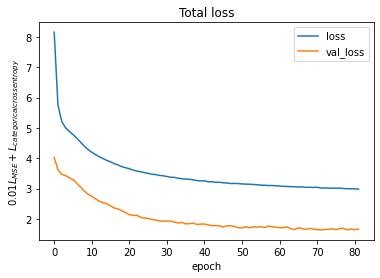

In [ ]:
plt.title('Total loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('$0.01L_{MSE} + L_{categorical crossentropy}$')
plt.savefig('./results/AE_dense_classifier/total_loss_mouse3.pdf')
plt.legend()

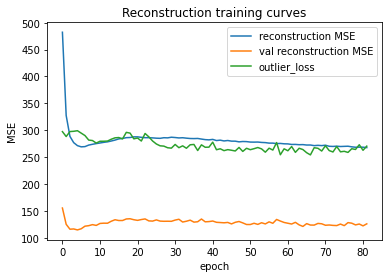

In [ ]:
#reconstruction loss
plt.title('Reconstruction training curves')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.plot(history.history['reconstruction_loss'], label='reconstruction MSE')
plt.plot(history.history['val_reconstruction_loss'], label='val reconstruction MSE')
plt.plot(history.history['reconstruction_outlier_loss'], label='outlier_loss')
plt.savefig('./results/AE_dense_classifier/rec_loss_mouse3.pdf')
plt.legend()

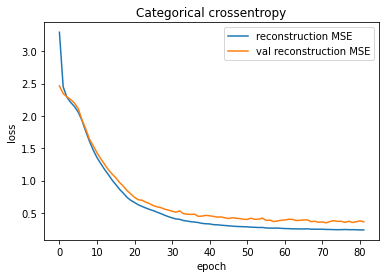

In [ ]:
#reconstruction loss
plt.title('Categorical crossentropy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(history.history['classifier_loss'], label='reconstruction MSE')
plt.plot(history.history['val_classifier_loss'], label='val reconstruction MSE')

plt.savefig('./results/AE_dense_classifier/cat_crossentropy_mouse3.pdf')
plt.legend()

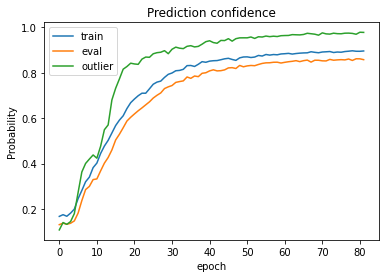

In [ ]:
#reconstruction loss
plt.title('Prediction confidence')
plt.xlabel('epoch')
plt.ylabel('Probability')
plt.plot(history.history['max_prob_train'], label='train')
plt.plot(history.history['max_prob_eval'], label='eval')
plt.plot(history.history['max_prob_outlier'], label='outlier')
plt.savefig('./results/AE_dense_classifier/max_prob_confidence_mouse3.pdf')
plt.legend()

## Testing

In [24]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, channels_train_enc)

KNeighborsClassifier(n_neighbors=3)

In [25]:
channels_anomaly = neigh.predict(X_anomaly)

In [26]:
#getting relevant data
encoded_train = encoder([X_train, channels_train_enc])
encoded_test = encoder([X_test, channels_test_enc])
encoded_test_all_spikes = encoder([X_test_all_spikes, channels_test_all_spikes_enc])

In [27]:
encoded_anomaly = encoder([X_anomaly, channels_anomaly])

In [28]:
decoded_train, pred_labels_train = autoencoder([X_train, channels_train_enc])
decoded_test, pred_labels_test = autoencoder([X_test, channels_test_enc])
decoded_test_all, pred_labels_test_all = autoencoder([X_test_all_spikes, channels_test_all_spikes_enc])

In [29]:
decoded_anomaly, pred_labels_anomaly = autoencoder([X_anomaly, channels_anomaly])

In [30]:
y_pred_test = np.argmax(pred_labels_test, axis=1)
y_pred_test_all = np.argmax(pred_labels_test_all, axis=1)
y_pred_train = np.argmax(pred_labels_train, axis=1)

### Classification accuracy

In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

#### On test dataset noisy spikes


In [32]:
print(classification_report(labels_test_all_spikes, y_pred_test_all))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      9000
           1       0.99      1.00      1.00      8991
           2       1.00      0.99      1.00      7000
           3       1.00      1.00      1.00      7826
           4       0.85      0.99      0.92      8000
           5       0.99      0.84      0.91      6452
           6       1.00      1.00      1.00      9000
           7       1.00      0.98      0.99      8000
           8       0.64      0.99      0.78      8000
           9       0.80      0.54      0.65      8000
          10       0.76      0.55      0.64      6636
          11       0.98      0.99      0.99      9000
          12       0.99      1.00      0.99      8000

    accuracy                           0.91    103905
   macro avg       0.91      0.90      0.90    103905
weighted avg       0.92      0.91      0.91    103905



In [33]:
disp = ConfusionMatrixDisplay(confusion_matrix(labels_test_all_spikes, y_pred_test_all, normalize='true'),
                              display_labels=[i for i in range(len(np.unique(labels_train)))])

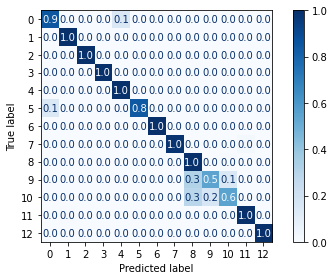

In [34]:
disp.plot(cmap=plt.cm.Blues, values_format='.1f')
disp.figure_.tight_layout()
disp.ax_.grid(False)
#plt.savefig('')

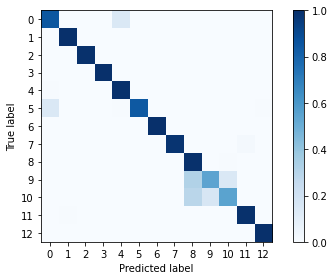

In [35]:
disp.plot(cmap=plt.cm.Blues, values_format='.1f', include_values=False)
disp.figure_.tight_layout()
disp.ax_.grid(False)
#plt.savefig('')

### Reconstruction

In [36]:
import seaborn as sns
color_list = sns.color_palette('deep', nb_neurons)

#### On noisy test data

In [37]:
y_test_all_spikes = tf.keras.utils.to_categorical(labels_test_all_spikes)

In [40]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

def plot_average_waveform_reconstructions(model,
                                  X_test,
                                  labels_test,
                                  test_channels,
                                  color_list,
                                  savefig,
                                  savefig_path,
                                  scale_shift=0,
                                  anomaly=False):
  fig, axs = plt.subplots(2, len(np.unique(labels_test)), figsize=(20, 4))
  scale = (np.min(X_test)+scale_shift, np.max(X_test)-scale_shift)
  for i, neuron_label in enumerate(np.unique(labels_test)):
      mask = labels_test == neuron_label
      mean_waveform = np.mean(X_test[mask], axis=0)
      current_channel = test_channels[mask][0]
      if anomaly:
        color = 'blue'
      else:
        color = color_list[neuron_label]
      axs[0, i].plot(mean_waveform,
                     c=color, lw=5.)
      
      axs[0, i].set_title('original')
      axs[0, i].set_xticks([])
      axs[0, i].set_yticks([])
      axs[0, i].set_ylim(scale)
      #reconstruction
      decoded_waveform, pred_label = model([np.reshape(mean_waveform, (1, -1)),
                                            np.reshape(current_channel, (1, -1))])
      pred_label = np.argmax(pred_label)
      if anomaly:
        color_pred = 'red'
      else:
        color_pred = color_list[pred_label] 
      axs[1, i].plot(decoded_waveform[0], c=color_pred, lw=5.)
      axs[1, i].set_title('reconstructed')
      axs[1, i].set_xticks([])
      axs[1, i].set_yticks([])
      axs[1, i].set_ylim(scale)
    
  if savefig:
    plt.savefig(savefig_path)
  fig.tight_layout()
  plt.show()

def plot_latent_space(encoded,
                      labels,
                      color_dic,
                      projection_method,
                      savefig,
                      savefig_path,
                      s=5.,
                      lw=1.,
                      borders=True,
                      sil_score_show=True,
                      edgecolor='black',
                      figsize=(10, 10),
                      xlim=(-25, 25),
                      ylim=(-20, 30),
                      title='UMAP embedding of AE latent space'):
  if projection_method == 'tsne':
    print('TSNE calculation under way')
    X_embedded = TSNE(n_components=2).fit_transform(encoded)
    plt.scatter(X_embedded[:, 0],
                X_embedded[:, 1],
                c=list(map(color_dic.get, labels)),
                s=2.)
    plt.xlabel('tSNE 1')
    plt.ylabel('tSNE 2')
    plt.title('tSNE embedding of AE latent space')
  elif projection_method == 'umap':
    print('UMAP calculation under way')
    X_embedded = umap.UMAP(n_neighbors=50,
                           min_dist=0.1,
                           metric='euclidean').fit_transform(encoded)
    
    plt.scatter(X_embedded[:, 0],
                X_embedded[:, 1],
                c=list(map(color_dic.get, labels)),
                s=2.)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title(title)                     
  elif projection_method == 'pca':
    print('PCA calculation under way')
    X_embedded = PCA(n_components=2).fit_transform(encoded)
    plt.scatter(X_embedded[:, 0],
                X_embedded[:, 1],
                s=2.,
                c=list(map(color_dic.get, labels)))
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.title('PCA embedding of AE latent space')
  elif projection_method == 'none':
    X_embedded = encoded
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(X_embedded[:, 0],
                X_embedded[:, 1],
                s=s,
                lw=lw,
                edgecolor=edgecolor,
                c=list(map(color_dic.get, labels)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if sil_score_show:
      if len(np.unique(labels)) > 1:
        sil_score = silhouette_score(X_embedded, labels)
        print('sil score '+str(sil_score))
    if borders:
      ax.set_xlabel('z 1')
      ax.set_ylabel('z 2')
      ax.set_title('AE latent space')
    else:
      ax.spines['top'].set_visible(False)
      ax.spines['right'].set_visible(False)
      ax.spines['left'].set_visible(False)
      ax.spines['bottom'].set_visible(False)

  if savefig:
    if 'jpg' in savefig_path.split('.')[-1]:
      print('saving jpg')
      plt.savefig(savefig_path, dpi=300)
    else:
      plt.savefig(savefig_path)
  plt.show()
  if sil_score_show:
    if len(np.unique(labels)) > 1:
      return X_embedded, sil_score
    else:
      return X_embedded
  else:
    return X_embedded

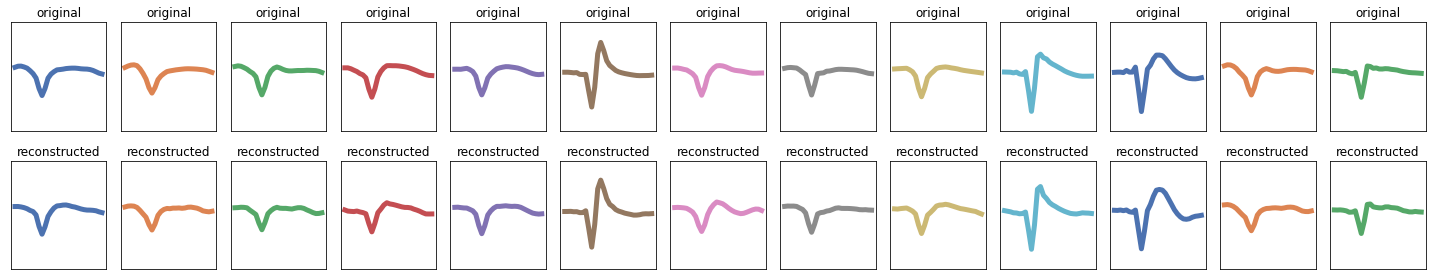

In [41]:
plot_average_waveform_reconstructions(autoencoder,
                              X_test_all_spikes, labels_test_all_spikes.astype('int'), channels_test_all_spikes_enc,
                              color_list,
                              False, '',
                              scale_shift=190)

### Latent space

#### Latent visualization of training data

In [42]:
from sklearn.metrics import silhouette_score

In [43]:
color_dic = dict([(i, val) for i, val in enumerate(color_list)])

In [44]:
encoded_train.shape

TensorShape([30729, 2])

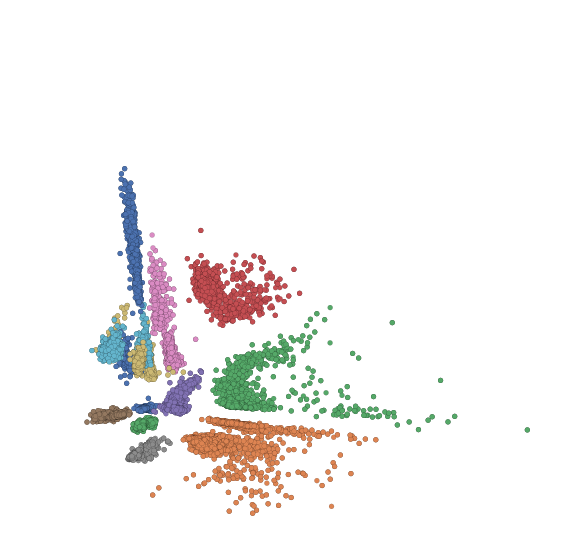

In [45]:
X_z_train = plot_latent_space(encoded_train.numpy(),
                  labels_train,
                  color_dic,
                  'none',
                  False, "",
                  s=25.,
                  lw=0.1,
                  borders=False,
                  xlim=(-20, 55),
                  ylim=(-20, 55),
                  sil_score_show=False)

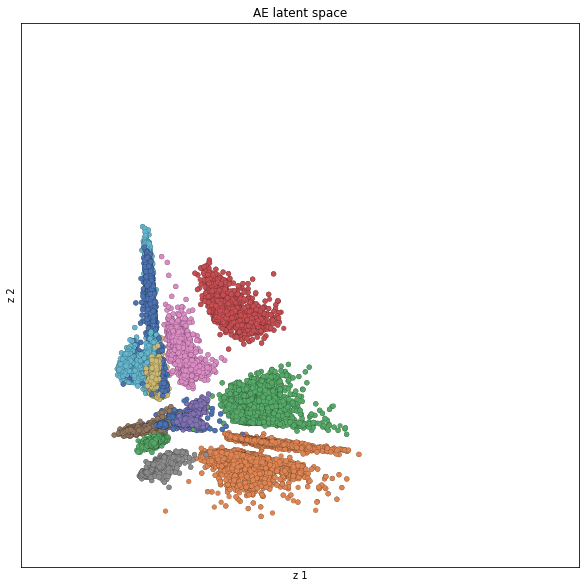

In [46]:
X_z_test_clean = plot_latent_space(encoded_test.numpy(),
                  labels_test,
                  color_dic,
                  'none',
                  False,
                  "",
                  s=25.,
                  xlim=(-20, 55),
                  ylim=(-20, 55),
                  lw=0.1,
                  sil_score_show=False)

processing channel 30
sil score 0.14822482


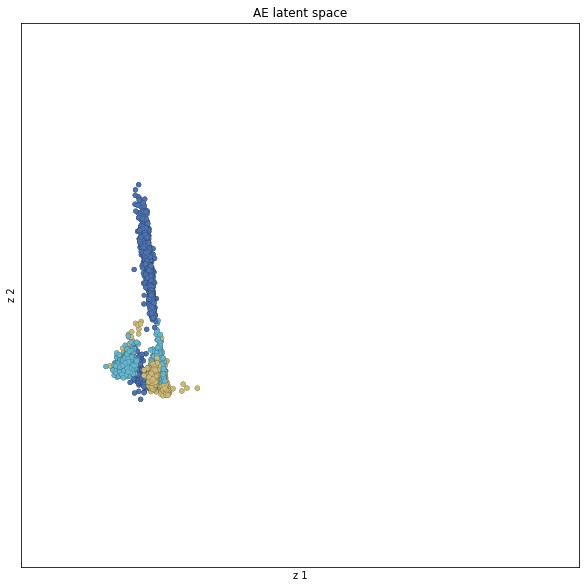

processing channel 16
sil score 0.8497288


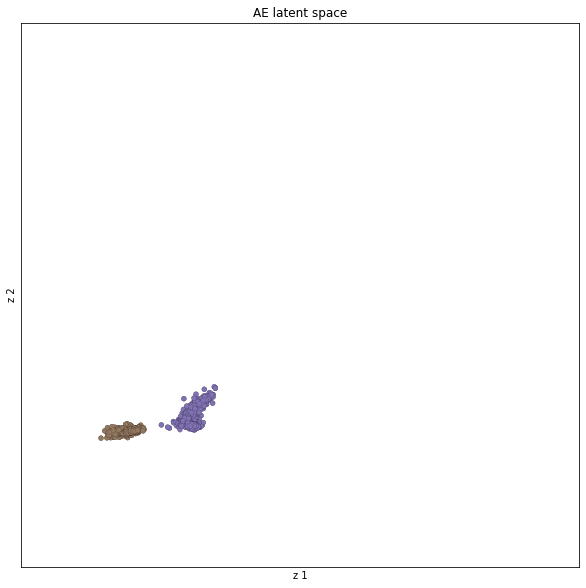

processing channel 14


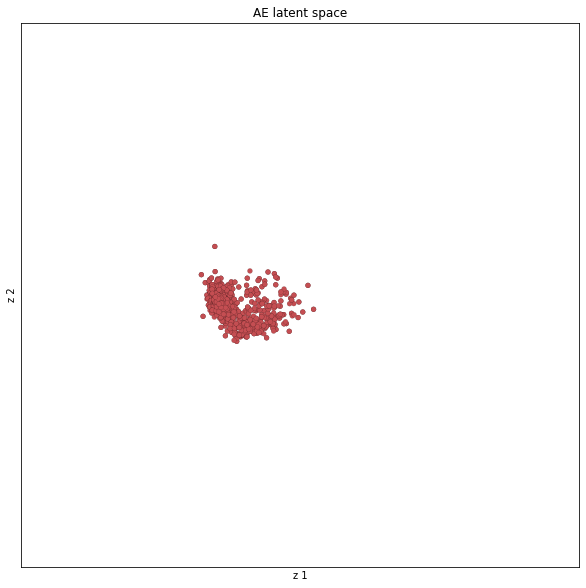

processing channel 10


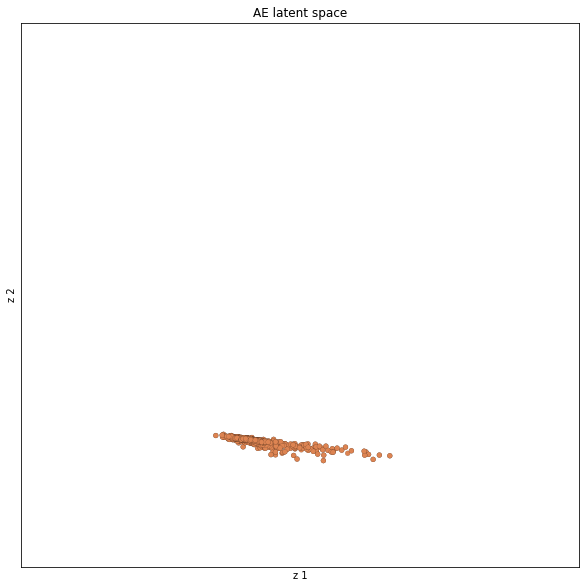

processing channel 25


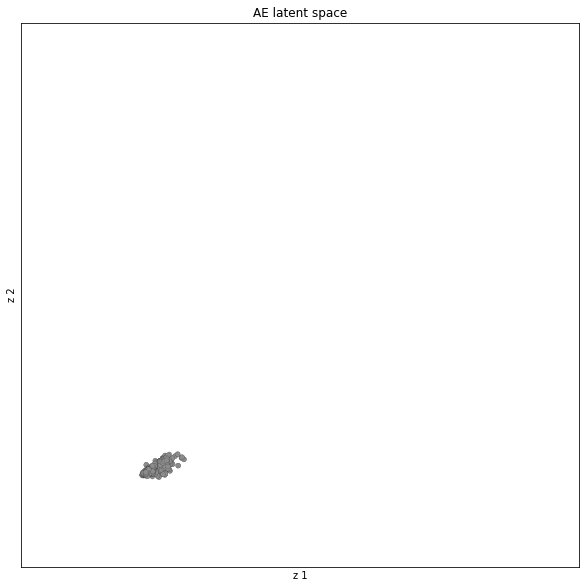

processing channel 20


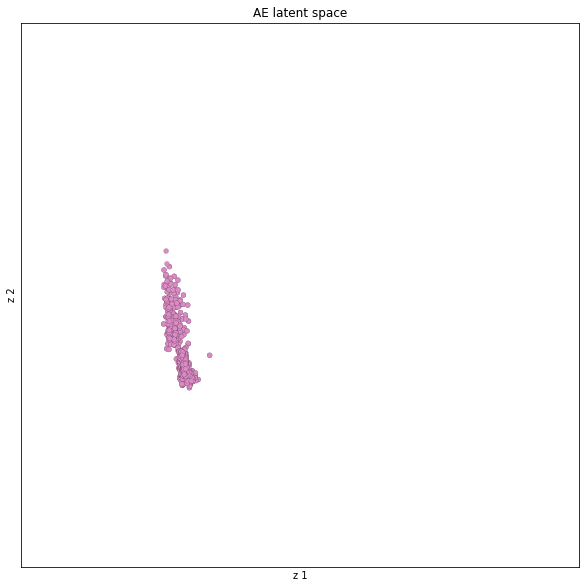

processing channel 31


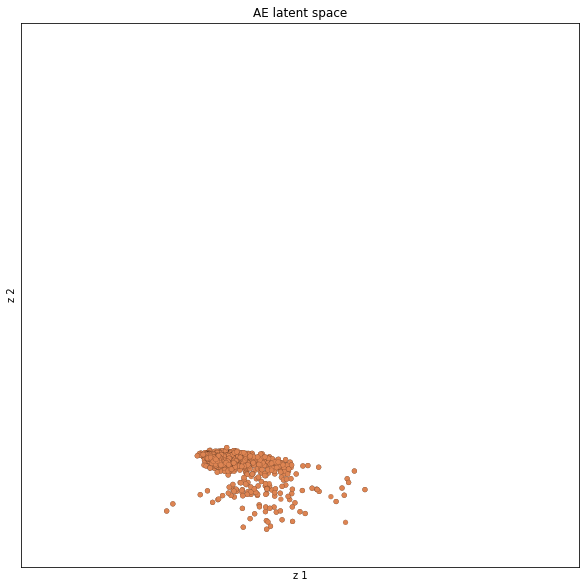

processing channel 8


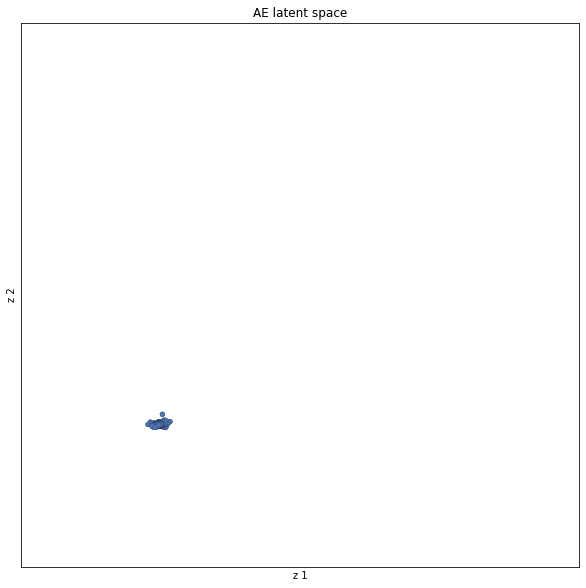

processing channel 32


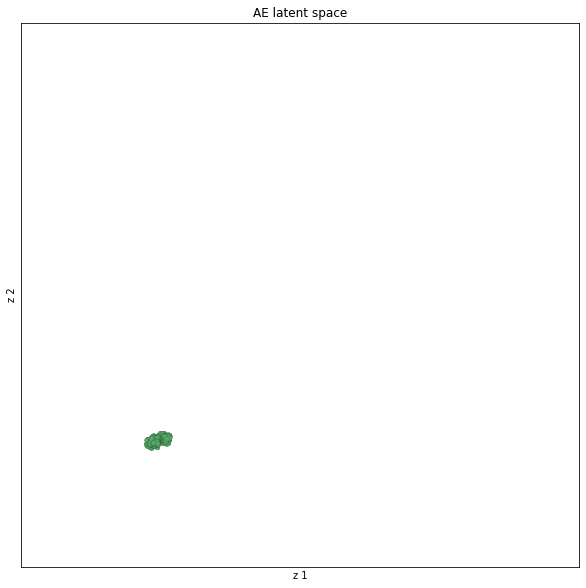

processing channel 12


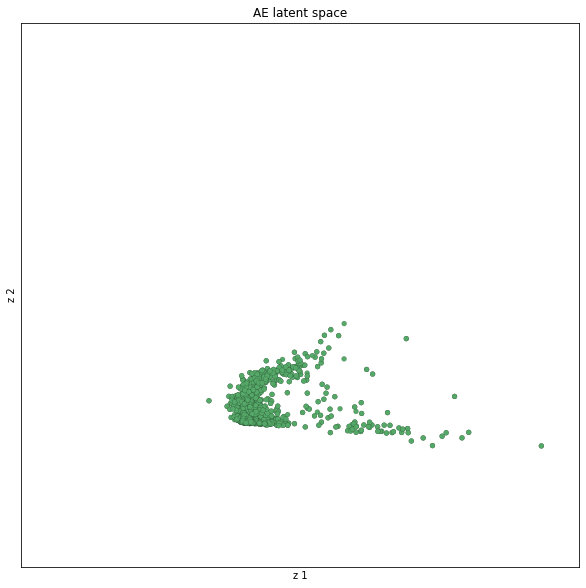

In [47]:
sil_scores_train = []
channels_train_sil_score = []

for channel in df_train['channel'].unique():
  print('processing channel '+str(channel))
  mask = df_train['channel'] == channel
  labels_ = labels_train[mask]
  encoded_ = encoded_train.numpy()[mask]
  if len(np.unique(labels_)) > 1:
    X_, sil_score_ = plot_latent_space(encoded_,
                                labels_,
                                color_dic,
                                'none',
                                False,
                                xlim=(-20, 55),
                                ylim=(-20, 55),
                                savefig_path=f'',
                                title=f'',
                                  sil_score_show=True,
                                  s=25.,
                                  lw=0.1,)
    sil_scores_train.append(sil_score_)
    channels_train_sil_score.append(channel)
  else:
    X_ = plot_latent_space(encoded_,
                                labels_,
                                color_dic,
                                'none',
                                False,
                                xlim=(-20, 55),
                                ylim=(-20, 55),
                                savefig_path=f'',
                                title=f'',
                              sil_score_show=False,
                              s=25.,
                              lw=0.1,)

#### Latent visualization on noisy test data

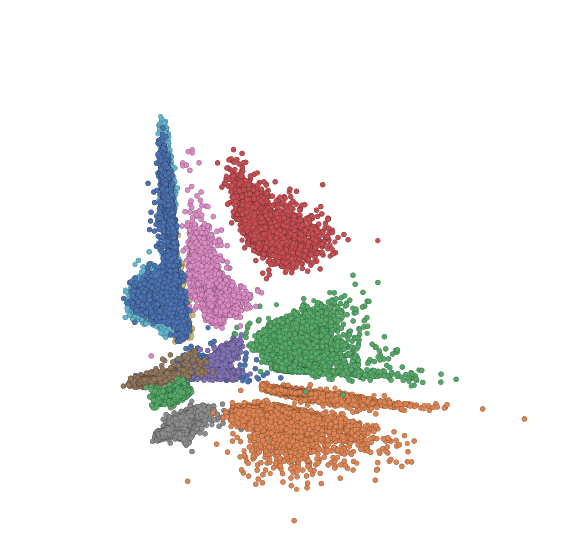

In [48]:
X_z = plot_latent_space(encoded_test_all_spikes.numpy(),
                  labels_test_all_spikes,
                  color_dic,
                  'none',
                  False, "",
                  sil_score_show=False,
                  borders=False,
                  s=25.,
                  xlim=(-20, 40),
                  ylim=(-20, 40),
                  lw=0.1)

processing channel 0
sil score 0.12753573


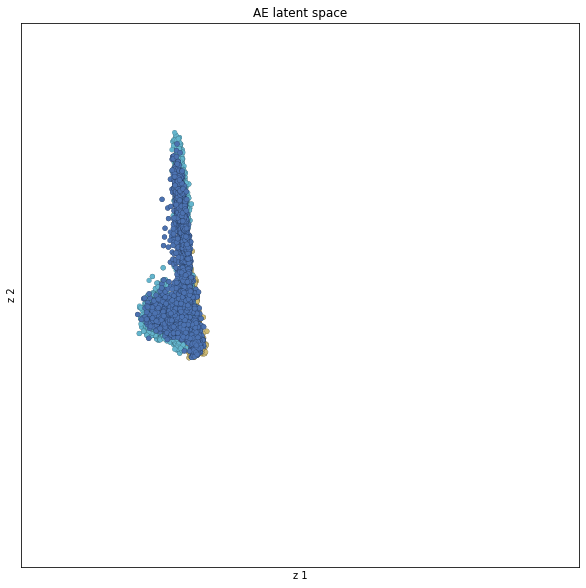

processing channel 1
sil score 0.79587936


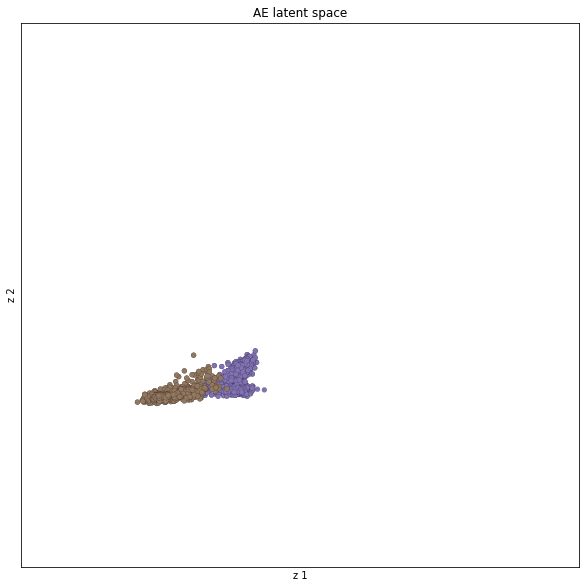

processing channel 2


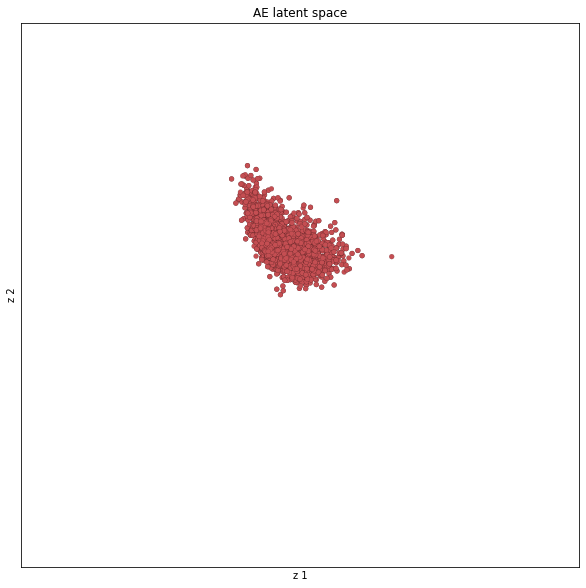

processing channel 3


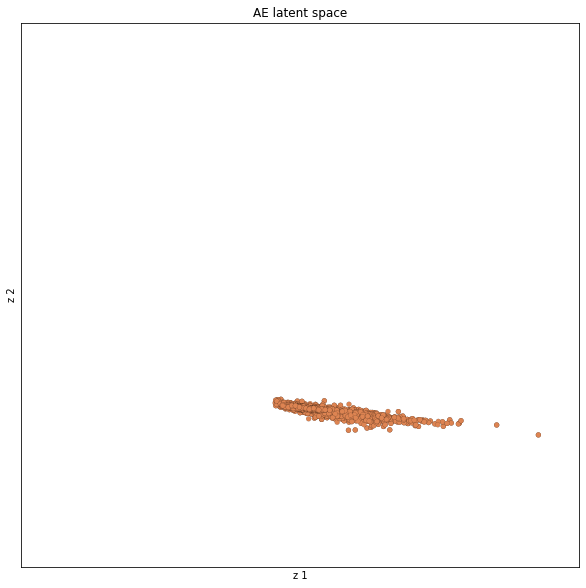

processing channel 4


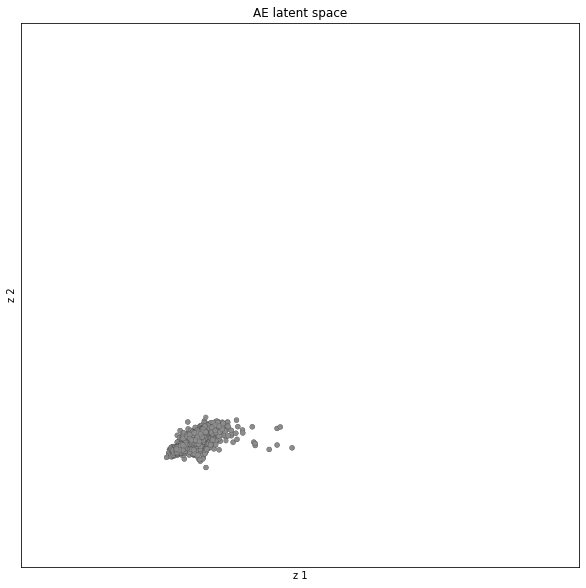

processing channel 5


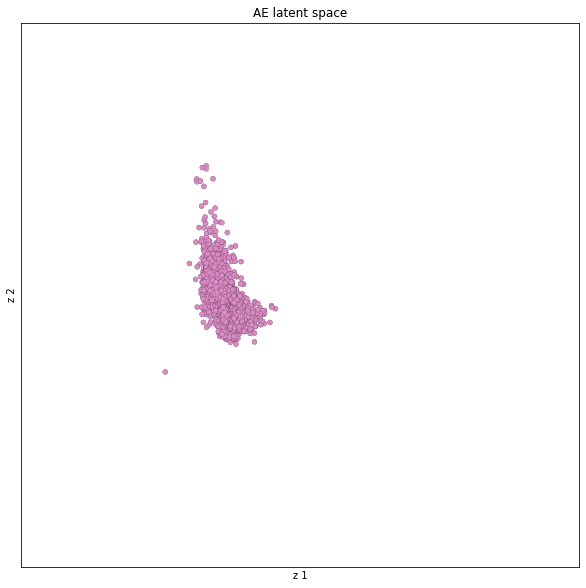

processing channel 6


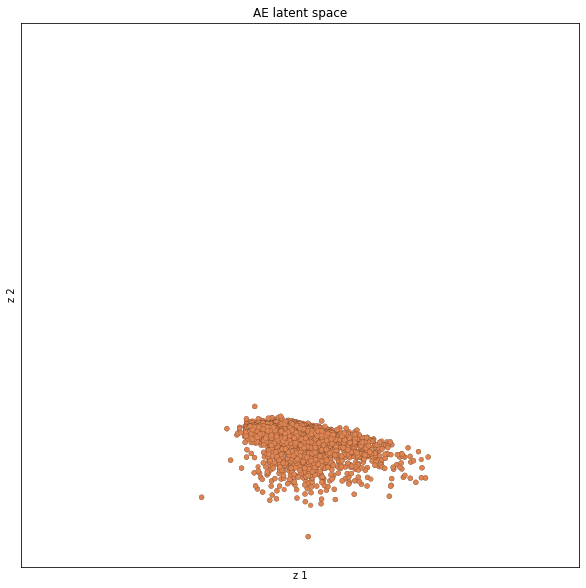

processing channel 7


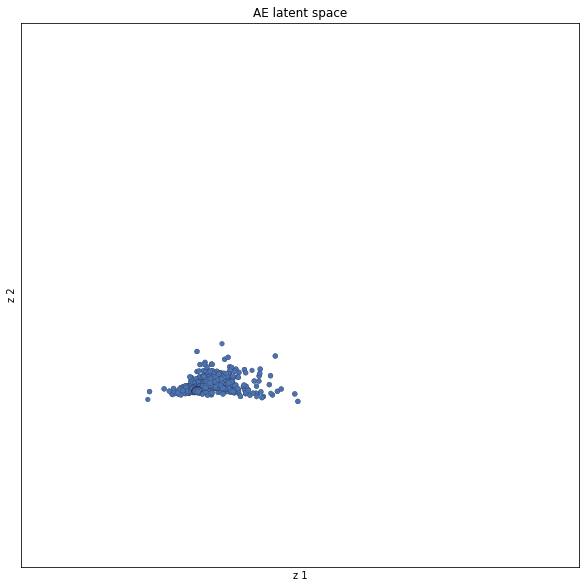

processing channel 8


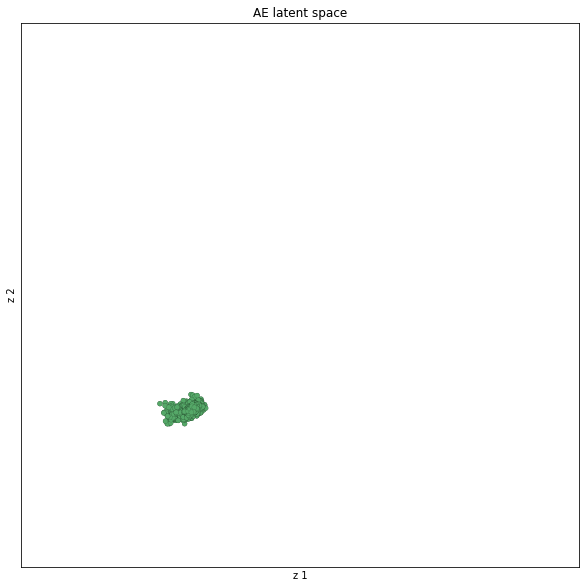

processing channel 9


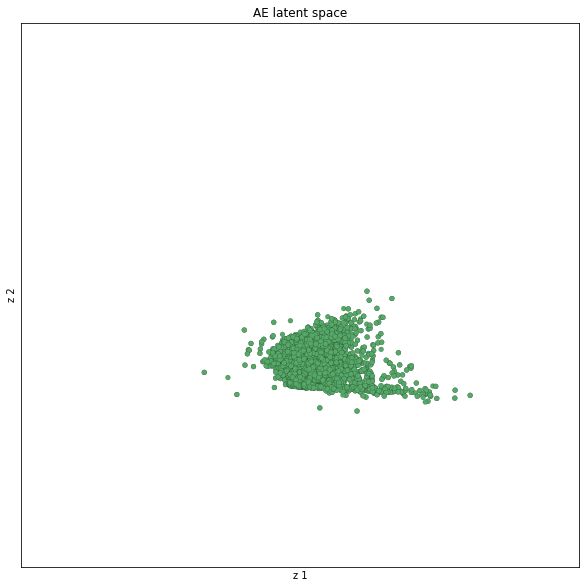

In [49]:
sil_scores_test = []
channels_test_sil_score = []

for channel in np.unique(channels_test_all_spikes):
  print('processing channel '+str(channel))
  mask = channels_test_all_spikes == channel
  labels_ = labels_test_all_spikes[mask]
  encoded_ = encoded_test_all_spikes.numpy()[mask]
  if len(np.unique(labels_)) > 1:
    X_, sil_score_ = plot_latent_space(encoded_,
                                labels_,
                                color_dic,
                                'none',
                                False,
                                f'',
                                title=f'',
                                sil_score_show=True,
                                xlim=(-20, 40),
                                ylim=(-20, 40),
                                lw=.1,
                                s=25.)
    sil_scores_test.append(sil_score_)
    channels_test_sil_score.append(channel)
  else:
    X_  = plot_latent_space(encoded_,
                              labels_,
                              color_dic,
                              'none',
                              False,
                              f'',
                              title=f'',
                              sil_score_show=False,
                              xlim=(-20, 40),
                                ylim=(-20, 40),
                              lw=.1,
                              s=25.)

#### Outlier data

In [50]:
color_list2 = sns.color_palette('tab10')
color_dic2 = dict([(i, val) for i, val in enumerate(color_list2)])

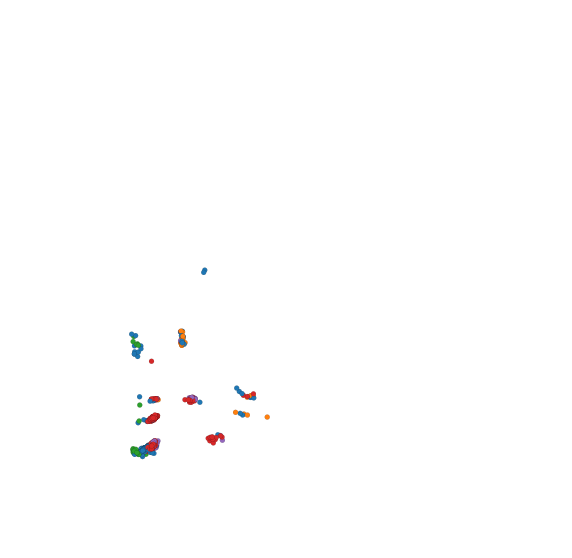

In [51]:
X_z_anomaly, sil_score_anomaly = plot_latent_space(encoded_anomaly.numpy(),
                  labels_anomaly,
                  color_dic2,
                  'none',
                  False, "",
                  lw=0.1,
                  s=25.,
                  xlim=(-20, 50),
                  ylim=(-20, 50),
                  figsize=(10, 10),
                  borders=False,
                  sil_score_show=True)

In [52]:
from scipy.spatial import ConvexHull

In [53]:
from descartes import PolygonPatch
import alphashape

In [54]:
hull_train = ConvexHull(encoded_train.numpy(), incremental=True)
hull_anomaly = ConvexHull(encoded_anomaly.numpy(), incremental=True)

In [55]:
alpha_shape_train = alphashape.alphashape(encoded_train.numpy(), 0.1)
alpha_shape_anomaly = alphashape.alphashape(encoded_anomaly.numpy(), 0.1)

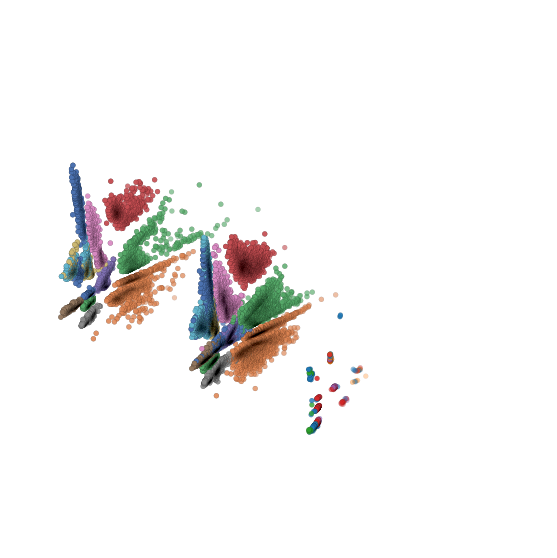

In [56]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")


ax.scatter(np.ones(encoded_test_all_spikes.numpy().shape[0])+0.5, encoded_test_all_spikes.numpy()[:, 0], 
           encoded_test_all_spikes.numpy()[:, 1], c=list(map(color_dic.get, labels_test_all_spikes)), s=25., lw=0.1, edgecolor='black')

ax.scatter(np.ones(encoded_train.numpy().shape[0]), encoded_train.numpy()[:, 0], 
           encoded_train.numpy()[:, 1], c=list(map(color_dic.get, labels_train)), s=25., lw=0.1, edgecolor='black')

ax.scatter(np.ones(encoded_anomaly.numpy().shape[0])+.9, encoded_anomaly.numpy()[:, 0], 
           encoded_anomaly.numpy()[:, 1], c=list(map(color_dic2.get, labels_anomaly)), s=25., lw=0.1, edgecolor='black')

ax.azim = -50
ax.set_xlim(1, 2)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_axis_off()
plt.show()

In [57]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull, Delaunay):
        hull = Delaunay(hull.points)

    return hull.find_simplex(p)>=0

In [ ]:
#get convex hull of each training neuron clust
convex_hulls_training = []
polygons = []

fig, ax = plt.subplots(figsize=(10, 10))

for i, neuron in enumerate(sorted(np.unique(labels_train))):
  mask = labels_train == neuron 
  X_train_ = encoded_train[mask]
  hull_ =  ConvexHull(X_train, incremental=True)
  convex_hulls_training.append(hull_)
  ax.scatter(X_train_[:, 0], X_train_[:, 1], c=list(map(color_dic.get,
                                                        labels_train[mask])),
             s=25., lw=.1, edgecolor='black')
  poly_ = plt.Polygon(X_train_[hull_.vertices, :], fc=None, ec=color_dic[neuron],
                           linewidth=3., fill=False, linestyle='--')
  #ax.add_patch(poly_)
  polygons.append(poly_)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim((-20, 55))
ax.set_ylim((-20, 55))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.show()

7
3
9
2
1
1
5
4
0
0
0
6
8


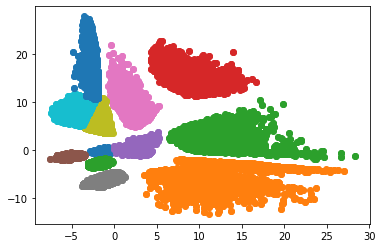

In [ ]:
#add processing for each predicted neuron in noisy dataset
X_test_no_noise = []
channel_test_no_noise = []
spikes_test_no_noise = []
labels_test_no_noise = []
real_labels_test_no_noise = []

X_test_rejected = []
channels_test_rejected = []
spikes_test_rejected = []
labels_test_rejected = []
real_labels_test_rejected = []

for i, neuron in enumerate(sorted(np.unique(y_pred_test_all))):
  mask1 = y_pred_test_all == neuron
  #make sure only one channel is used for a given neuron
  channel_ = np.array(channels_test_all_spikes)[mask1]
  values, channel_counts = np.unique(channel_, return_counts=True)
  print(np.unique(channel_)[np.argmax(channel_counts)])
  max_chan = np.unique(channel_)[np.argmax(channel_counts)]
  mask2 = np.array(channels_test_all_spikes) == max_chan
  mask = mask1 & mask2
  #current
  channel_ = np.array(channels_test_all_spikes)[mask]
  X_test_ = encoded_test_all_spikes.numpy()[mask]
  y_pred_ = y_pred_test_all[mask]
  spikes_ = X_test_all_spikes[mask]
  labels_test_ = labels_test_all_spikes[mask]
  #keep rejected
  channels_test_rejected.append(np.array(channels_test_all_spikes)[mask1&~mask2])
  labels_test_rejected.append(y_pred_test_all[mask1&~mask2])
  real_labels_test_rejected.append(labels_test_all_spikes[mask1&~mask2])
  spikes_test_rejected.append(X_test_all_spikes[mask1&~mask2])
  X_test_rejected.append(encoded_test_all_spikes.numpy()[mask1&~mask2])
  #rejection
  new_mask = in_hull(X_test_, convex_hulls_training[i])
  X_test_no_noise.append(X_test_[new_mask])
  #append
  channel_test_no_noise.append(channel_[new_mask])
  labels_test_no_noise.append(y_pred_[new_mask])
  real_labels_test_no_noise.append(labels_test_[new_mask])
  spikes_test_no_noise.append(spikes_[new_mask])

  X_test_rejected.append(X_test_[~new_mask])
  channels_test_rejected.append(channel_[~new_mask])
  labels_test_rejected.append(y_pred_[~new_mask])
  real_labels_test_rejected.append(labels_test_[~new_mask])
  spikes_test_rejected.append(spikes_[~new_mask])

In [ ]:
X_test_no_noise = np.vstack(X_test_no_noise)
channel_test_no_noise = np.hstack(channel_test_no_noise)
labels_test_no_noise = np.hstack(labels_test_no_noise)
real_labels_test_no_noise = np.hstack(real_labels_test_no_noise)
spikes_test_no_noise = np.vstack(spikes_test_no_noise)

In [ ]:
X_test_rejected = np.vstack(X_test_rejected)
channels_test_rejected = np.hstack(channels_test_rejected)
labels_test_rejected = np.hstack(labels_test_rejected)
real_labels_test_rejected = np.hstack(real_labels_test_rejected)
spikes_test_rejected = np.vstack(spikes_test_rejected)

In [ ]:
df_rejection = pd.DataFrame(rejection_probs, columns=['Percentage_noise'])
df_rejection['count_normal'] = counts_no_noise
df_rejection['count_noise'] = counts_rejected
df_rejection['label'] =  labels_rejection
df_rejection['mouse'] = 3

In [ ]:
#df_rejection.to_csv('')

In [ ]:
xlims = []
ylims = []

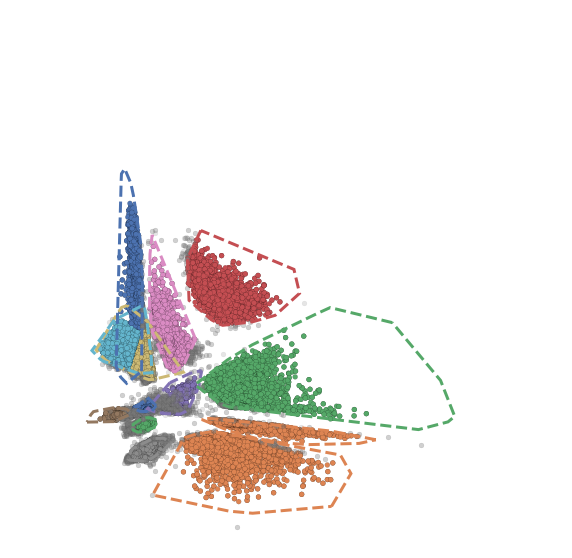

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

for i, channel in enumerate(np.unique(channel_test_no_noise)):
  mask = np.array(channel_test_no_noise) == channel
  mask_noise = np.array(channels_test_rejected) == channel
  X_ = X_test_no_noise[mask]
  X_rejected_ = X_test_rejected[mask_noise]
  neurons_ = np.unique(labels_test_no_noise[mask])
  ax.scatter(X_[:, 0], X_[:, 1],
               s=25., lw=0.1, c=list(map(color_dic.get, labels_test_no_noise[mask])),
               edgecolor='black')
  ax.scatter(X_rejected_[:, 0], X_rejected_[:, 1],
               s=25., lw=0.1, color='grey', alpha=0.2,
               edgecolor='black')
  for n in neurons_:
   ax.add_patch(polygons[n])
  # ax.set_xlabel('z1')
  # ax.set_ylabel('z2')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim((-20, 55))
ax.set_ylim((-20, 55))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

#### Latent space metrics

In [ ]:
sil_scores_train, sil_scores_test, sil_score_anomaly

([0.1482248, 0.8497288], [0.12753573, 0.79587936], 0.13530746)

In [ ]:
list_sil_scores = sil_scores_train+sil_scores_test+[sil_score_anomaly]

In [ ]:
list_dataset_type = ['train' for _ in sil_scores_train]+['test' for _ in sil_scores_test]+['anomaly']

df_sil_score = pd.DataFrame(list_sil_scores, columns=['silhouette_score'])
df_sil_score['dataset_type'] = list_dataset_type
df_sil_score['mouse'] = 3


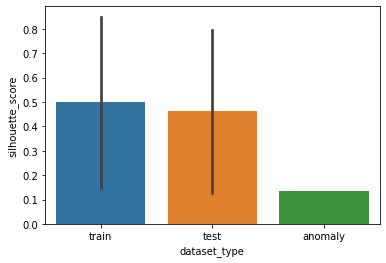

In [ ]:
sns.barplot(x='dataset_type', y='silhouette_score', data=df_sil_score)
#plt.savefig('')

In [ ]:
#df_sil_score.to_csv('')

## Using MSE for anomaly detection

In [ ]:
channels_anomaly = np.ones(channels_anomaly.shape)*5
encoded_anomaly = encoder([X_anomaly, channels_anomaly])
decoded_anomaly, pred_labels_anomaly = autoencoder([X_anomaly, channels_anomaly])

In [ ]:
mse_train = ((decoded_train.numpy() - X_train)**2).mean(axis=1)
mse_test = ((decoded_test.numpy() - X_test)**2).mean(axis=1)
mse_test_noisy = ((decoded_test_all.numpy() - X_test_all_spikes)**2).mean(axis=1)
# mse_outlier = ((decoded_outlier.numpy() - X_outlier)**2).mean(axis=1)
mse_anomaly = ((decoded_anomaly.numpy() - X_anomaly)**2).mean(axis=1)

In [ ]:
threshold = np.mean(mse_train) + .5*np.std(mse_train)

In [ ]:
threshold

435.7902371533012

In [ ]:
df_plot1 = pd.DataFrame(np.hstack([mse_train, mse_test_noisy, mse_anomaly]), columns=['mse'])
df_plot1['type'] = np.hstack([['train' for _ in range(len(mse_train))],
                        ['test' for _ in range(len(mse_test_noisy))],
                        ['anomaly' for _ in range(len(mse_anomaly))]])

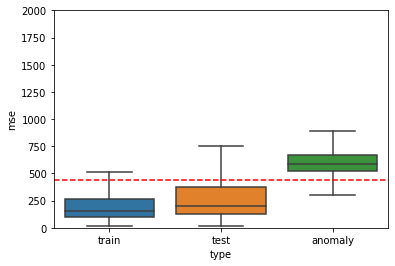

In [ ]:
ax = sns.boxplot(x="type", y="mse", data=df_plot1, fliersize=0.)
plt.axhline(threshold, c='r', linestyle='--')
plt.ylim(0, 2000)
plt.savefig('./results/AE_dense_classifier/mse_anomaly_detection_mouse3.pdf')
plt.show()

In [ ]:
df_plot1['mouse'] = 3

In [ ]:
#df_plot1.to_csv('')